In [1]:
import sqlite3 as lite
import os
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image
import matplotlib.pyplot as plt
import os
from shutil import copyfile

In [2]:
import analysis as an

In [3]:
# sqlite file with only the legacy lwrs from 2013/05

In [4]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('./legacy_only.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

In [5]:
# get number of reactors and capacity timeseries
an.plot_power(cur)

Sink_Source_Inst has no values
Sink_Source_Inst has no values


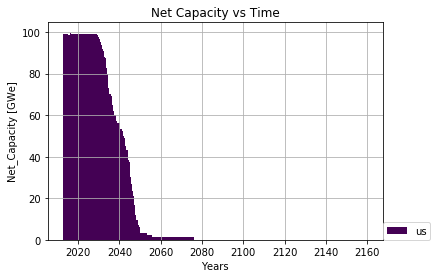

In [6]:
Image('power_plot.png')

In [7]:
cur = an.get_cursor('./legacy_only.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)
power_dict = an.get_power_dict(cur)
for key, val in power_dict.items():
    # start from 2020 -> 6 years and 7 months (80 months later)
    power_dict[key] = val[80:]

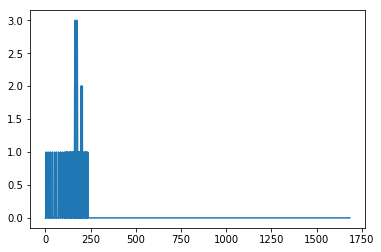

In [9]:
lwr_deploy_array, lwr_deployed_power = an.get_new_deployment(power_dict, ['us_government'],
                                                     '100*(1.01)**(t/12)', 1, 960, 240, False)
power_dict['lwr'] = lwr_deployed_power
plt.plot(lwr_deploy_array)

In [13]:
an.write_deployinst(deploy_array, 'lwr', 'lwr_dep.xml', 960)

## With LWRs deployed, the power looks like:

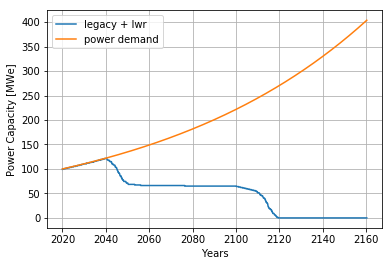

In [18]:
x = np.arange(0, 1684)
years = 2020 + x/12
y = 100*(1.01)**(x/12)
plt.plot(years, power_dict['us_government'] + power_dict['lwr'], label='legacy + lwr')
plt.plot(years, y, label='power demand')
plt.xlabel('Years')
plt.ylabel('Power Capacity [MWe]')
plt.legend()
plt.grid()

## To fill in the lack from 2020, deploy MSRs:

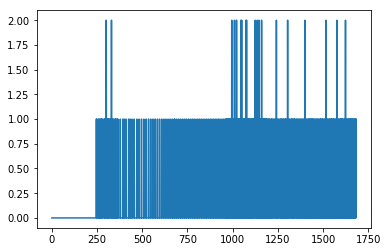

In [20]:
# rebus
msr_power = 3.7*0.44
lifetime = 60*12
msr_deploy_array, msr_deployed_power = an.get_new_deployment(power_dict, ['us_government', 'lwr'],
                                                     '100*(1.01)**(t/12)', msr_power, lifetime, 240, True)
power_dict['msr'] = msr_deployed_power
plt.plot(msr_deploy_array)

## Now the total deployed power is:

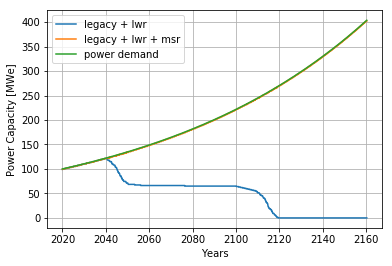

In [21]:
x = np.arange(0, 1684)
years = 2020 + x/12
y = 100*(1.01)**(x/12)
plt.plot(years, power_dict['us_government'] + power_dict['lwr'], label='legacy + lwr')
plt.plot(years, power_dict['us_government'] + power_dict['lwr'] + power_dict['msr'], label='legacy + lwr + msr')
plt.plot(years, y, label='power demand')
plt.xlabel('Years')
plt.ylabel('Power Capacity [MWe]')
plt.legend()
plt.grid()